# Tutorial on ProfileHistogram

In [1]:
from matplotlib import pyplot as plt
import poisson_approval as pa

## Profile

Generate a random profile:

In [2]:
generator_profile = pa.GeneratorProfileHistogramUniform(n_bins = 10)
profile = generator_profile()
profile

<abc: 0.23584266515105823 [0.32905246 0.05086927 0.08412409 0.16542357 0.03159868 0.0075145
 0.00950813 0.26427174 0.02018049 0.03745708], acb: 0.13100429768458766 [0.28224815 0.01645788 0.03149529 0.036729   0.22698395 0.05836253
 0.05303298 0.10786256 0.03640244 0.15042521], bac: 0.01689429074642268 [0.00341629 0.01248218 0.04036559 0.15091306 0.30879437 0.01995679
 0.32855364 0.00150202 0.07978717 0.05422888], bca: 0.14313356596626325 [0.14978739 0.0315621  0.0733023  0.09504868 0.21032482 0.02039006
 0.06032449 0.17238151 0.09090097 0.09597769], cab: 0.39831122421598175 [0.02244039 0.00228905 0.16858019 0.11659089 0.12601785 0.02971328
 0.09460164 0.02019142 0.17544016 0.24413513], cba: 0.07481395623568643 [0.04197074 0.01088197 0.07398063 0.08663419 0.00108959 0.08801202
 0.18322173 0.1944935  0.0336268  0.28608882]> (Condorcet winner: c)

Share of each ranking:

In [3]:
profile.d_ranking_share

{abc: 0.23584266515105823, acb: 0.13100429768458766, bac: 0.01689429074642268, bca: 0.14313356596626325, cab: 0.39831122421598175, cba: 0.07481395623568643}

Distribution of the utilities for voters $abc$:

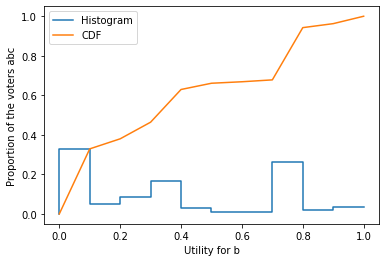

In [4]:
ranking = 'abc'
profile.plot_histogram(ranking, label='Histogram')
profile.plot_cdf(ranking, label='CDF')
plt.ylabel('Proportion of the voters %s' % ranking)
plt.legend()

## Strategic Analysis

Generate a random strategy:

In [5]:
generator_strategy = pa.GeneratorStrategyThresholdUniform()
strategy = generator_strategy()
strategy

<abc: utility-dependent (0.7986445841944864), acb: utility-dependent (0.672568357209391), bac: utility-dependent (0.5751115785872648), bca: utility-dependent (0.8173746035999343), cab: utility-dependent (0.5314651994046576), cba: utility-dependent (0.8012197220188538)>

Tau vector (ballot shares) associated to the strategy in the given profile:

In [6]:
tau = profile.tau(strategy)
tau

<a: 0.31189726848992966, ab: 0.02236225824806984, ac: 0.2614676054030505, b: 0.12761577802738255, bc: 0.04837650922482575, c: 0.22828058060674175> ==> a

Is the strategy an equilibrium for the given profile?

In [7]:
profile.is_equilibrium(strategy)

EquilibriumStatus.NOT_EQUILIBRIUM

Use iterated voting to search for an equilibrium:

In [8]:
result = profile.iterated_voting(strategy_ini=strategy, n_max_episodes=1000, 
                                 ballot_update_ratio=0.1)
cycle_taus_actual = result['cycle_taus_actual']
cycle_strategies = result['cycle_strategies']

In [9]:
cycle_taus_actual

[<a: 0.22332150149690577, ab: 0.16041975208516293, bc: 0.1690442871655397, c: 0.4472144592523917> ==> c]

In [10]:
if len(cycle_taus_actual) == 0:
    print('No convergence.')
elif len(cycle_taus_actual) == 1:
    print('Convergence to an equilibrium.')
    print('Limit strategy: %s' % cycle_strategies[0])
    print('Limit tau-vector: %s' % cycle_taus_actual[0])
else:
    print('Convergence to a cycle of cardinality %s.' % len(cycle_taus_actual))

Convergence to an equilibrium.
Limit strategy: <abc: utility-dependent (0.21368671470724906), acb: a, bac: ab, bca: bc, cab: c, cba: utility-dependent (0.7863132852927509)> ==> c
Limit tau-vector: <a: 0.22332150149690577, ab: 0.16041975208516293, bc: 0.1690442871655397, c: 0.4472144592523917> ==> c


There is another version of iterated voting, ``fictitious_play``. It allows for update ratios that depend on time, it is faster, but it is not able to detect limit cycles (only convergence). Cf. Reference section for more information.

In [11]:
from math import log
result = profile.fictitious_play(strategy_ini=strategy, n_max_episodes=1000, 
                                 perception_update_ratio=lambda t: 1 / log(t + 2),
                                 ballot_update_ratio=0.1)
limit_tau = result['tau']
limit_strategy = result['strategy']

In [12]:
if limit_tau is None:
    print('No convergence.')
else:
    print('Convergence to an equilibrium.')
    print('Limit strategy: %s' % limit_strategy)
    print('Limit tau-vector: %s' % limit_tau)

Convergence to an equilibrium.
Limit strategy: <abc: utility-dependent (0.21368671420404697), acb: a, bac: ab, bca: bc, cab: c, cba: utility-dependent (0.786313285795953)> ==> c
Limit tau-vector: <a: 0.22332150139706997, ab: 0.1604197521849986, bc: 0.1690442870923193, c: 0.4472144593256121> ==> c


The methods ``iterated_voting`` and ``fictitious_play`` also provide the winning frequency of each candidate. In case of convergence to a limit or a periodical orbit, these frequencies are computed at the limit. In case of non-convergence, it gives the winning frequencies on the history of the process.

In [13]:
result = profile.iterated_voting(strategy_ini=strategy, n_max_episodes=10, 
                                 ballot_update_ratio=0.1)
result['d_candidate_winning_frequency']

{a: 3/11, c: 8/11}

If you want to convert these winning frequencies to an array, you can use the function ``d_candidate_value_to_array``:

In [14]:
pa.d_candidate_value_to_array(result['d_candidate_winning_frequency'])

array([Fraction(3, 11), 0, Fraction(8, 11)], dtype=object)